In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

In [2]:
# set to be able to read all data without ellipsis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import the Data

There are a total of three different datasets. Each dataset will be read into their own respective DataFrames. Below are the three datasets and their corresponding DataFrames:

1. pokemon.csv -> pokemon
2. combats.csv -> combats
3. tests.csv -> tests

In [3]:
# read in stats/information about each pokemon
pokemon = pd.read_csv('pokemon.csv')
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [4]:
# read in recorded pokemon battles and the winners of each battle
combats = pd.read_csv('combats.csv')
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [5]:
# test data used to run in the model
tests = pd.read_csv('tests.csv')
tests.head()

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656


# Exploratory Data Analysis

In this phase of the report, I am going to look at each DataFrame in detail to find any errors, outliers, and missing data. Additionally, I am hoping it will also shine some light on any potential trends to further uncover in the data.

## Overall Pokemon

My first step is to look at the general details of the entire Pokemon DataFrame. This includes the shape of the DataFrame, knowing the columns, finding missing information, etc.

In [6]:
# determining the size of the DataFrame
print(f"Dataframe dimensions: {pokemon.shape}")

Dataframe dimensions: (800, 12)


In [7]:
# Getting a breakdown of the columns in the DataFrame. This makes it easy to reference columns in my later work.
print('Below are the columns in the Pokemon DataFrame:')
print('-----------------------------------------------\n')

for i in range(len(pokemon.columns)):
    print(f'Column {i}: {pokemon.columns[i]}')

Below are the columns in the Pokemon DataFrame:
-----------------------------------------------

Column 0: #
Column 1: Name
Column 2: Type 1
Column 3: Type 2
Column 4: HP
Column 5: Attack
Column 6: Defense
Column 7: Sp. Atk
Column 8: Sp. Def
Column 9: Speed
Column 10: Generation
Column 11: Legendary


In [8]:
# Getting general information about each column
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


So far, the Pokemon DataFrame has 800 rows and 12 columns. Within those columns, the Name column has a missing entry. Additionally, the Type 2 column has 386 missing entries, however, this makes sense because it is not required for a Pokemon to have multiple types. 

Before figuring out what the missing Pokemon name is, I want to conduct further EDA with the use of the ydata profiling library. 

In [78]:
pokemon_profile = ProfileReport(pokemon, title = "Pokemon DataFrame Profiling Report")
pokemon_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

The next step is to find the missing Pokemon name and then replace it with the actual Pokemon name based on the National Index.

In [10]:
# https://datatofish.com/rows-with-nan-pandas-dataframe/
pokemon[pokemon['Name'].isna()]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False


In [11]:
print(f'The Pokemon before the missing name is: {pokemon["Name"][61]}')
print(f'The Pokemon after the missing name is: {pokemon["Name"][63]}')

The Pokemon before the missing name is: Mankey
The Pokemon after the missing name is: Growlithe


Based off the information above and the national Pokedex, the missing Pokemon name is Primeape. I will replace the missing entry with Primeape to complete the data.

In [12]:
# https://www.pokemon.com/us/pokedex
pokemon['Name'].replace(np.nan, 'Primeape', inplace = True)

In [13]:
# double checking that there isn't any missing data left
pokemon.isna().sum()

#               0
Name            0
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

### Pokemon - Type One

Now it is time to look at the specific details of the first type of each Pokemon.

In [14]:
typeone_breakdown = pokemon['Type 1'].value_counts()
typeone_breakdown

Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ground       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: Type 1, dtype: int64

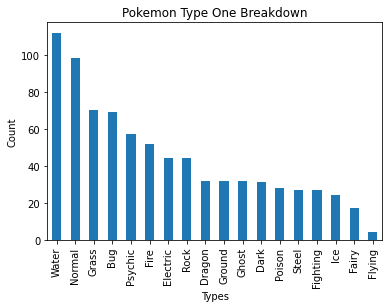

In [15]:
typeone_breakdown.plot.bar()
plt.title("Pokemon Type One Breakdown")
plt.xlabel("Types")
plt.ylabel("Count")
plt.show()

Out of the 800 Pokemon, the top three first types are Water, Normal, and Grass. The bottom three first types are Flying, Fairy, and Ice. This makes me believe just be odds alone that Pokemon with a Water, Normal, or Grass type are more likely to win battles. 

In [16]:
gen_typeone = pokemon.groupby(['Generation'])['Type 1'].value_counts()

In [17]:
gen_typeone

Generation  Type 1  
1           Water       31
            Normal      24
            Bug         14
            Fire        14
            Poison      14
            Grass       13
            Psychic     11
            Rock        10
            Electric     9
            Ground       8
            Fighting     7
            Ghost        4
            Dragon       3
            Fairy        2
            Ice          2
2           Water       18
            Normal      15
            Bug         12
            Grass        9
            Fire         8
            Electric     7
            Psychic      7
            Dark         6
            Fairy        5
            Rock         5
            Ice          4
            Ground       3
            Steel        3
            Fighting     2
            Ghost        1
            Poison       1
3           Water       27
            Normal      18
            Grass       13
            Bug         12
            Dragon      12
       

In [18]:
legend_typeone = pokemon.groupby(['Legendary'])['Type 1'].value_counts()

In [19]:
legend_typeone

Legendary  Type 1  
False      Water       108
           Normal       96
           Bug          69
           Grass        67
           Fire         47
           Psychic      43
           Electric     40
           Rock         40
           Ghost        30
           Dark         29
           Ground       28
           Poison       28
           Fighting     27
           Steel        23
           Ice          22
           Dragon       20
           Fairy        16
           Flying        2
True       Psychic      14
           Dragon       12
           Fire          5
           Electric      4
           Ground        4
           Rock          4
           Steel         4
           Water         4
           Grass         3
           Dark          2
           Flying        2
           Ghost         2
           Ice           2
           Normal        2
           Fairy         1
Name: Type 1, dtype: int64

The top three different first types of Pokemon for Legendary Pokemon are Psychic, Dragon, and Fire. Since Legendary Pokemon tend to be stronger than regular Pokemon, this could change which types are winning more often. 

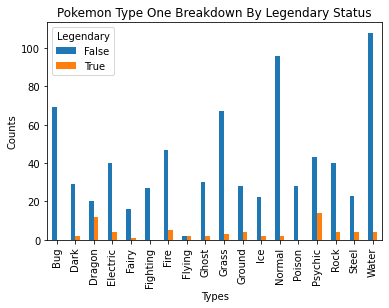

In [20]:
# https://stackoverflow.com/questions/34248741/plotting-pandas-multiindex-bar-chart
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html
legend_typeone.unstack(level = 0).plot(kind = 'bar')
plt.title('Pokemon Type One Breakdown By Legendary Status')
plt.xlabel('Types')
plt.ylabel('Counts')
plt.show()

### Pokemon - Type Two

Now it is time to look at the specific details of the second type for Pokemon. My belief is that there is an inverse from the first type because a Pokemon can't be a Water and Water Pokemon. Additionally, I believe it would be inverse to help balance out the game in general between types.

In [21]:
typetwo_breakdown = pokemon['Type 2'].value_counts()
typetwo_breakdown

Flying      97
Ground      35
Poison      34
Psychic     33
Fighting    26
Grass       25
Fairy       23
Steel       22
Dark        20
Dragon      18
Water       14
Ghost       14
Ice         14
Rock        14
Fire        12
Electric     6
Normal       4
Bug          3
Name: Type 2, dtype: int64

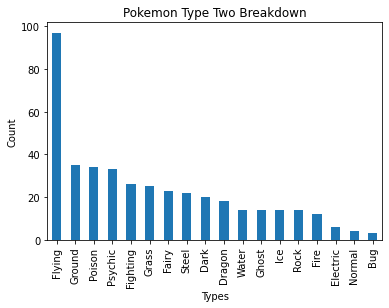

In [22]:
typetwo_breakdown.plot.bar()
plt.title("Pokemon Type Two Breakdown")
plt.xlabel("Types")
plt.ylabel("Count")
plt.show()

In [23]:
pokemon.groupby(['Generation'])['Type 2'].value_counts()

Generation  Type 2  
1           Flying      23
            Poison      22
            Psychic      7
            Ground       6
            Water        4
            Fairy        3
            Ice          3
            Fighting     2
            Grass        2
            Rock         2
            Steel        2
            Dark         1
            Dragon       1
2           Flying      19
            Ground       8
            Fairy        3
            Fire         3
            Poison       3
            Psychic      3
            Rock         3
            Steel        3
            Dark         2
            Dragon       2
            Electric     2
            Fighting     2
            Grass        1
            Ice          1
3           Psychic     16
            Flying      14
            Ground       9
            Fairy        8
            Dark         7
            Grass        5
            Fighting     4
            Rock         4
            Water        4
       

In [24]:
legend_typetwo = pokemon.groupby(['Legendary'])['Type 2'].value_counts()
legend_typetwo

Legendary  Type 2  
False      Flying      84
           Ground      34
           Poison      34
           Psychic     28
           Grass       25
           Fighting    22
           Fairy       21
           Steel       21
           Dark        19
           Dragon      14
           Rock        14
           Ghost       13
           Water       13
           Ice         11
           Fire         9
           Electric     5
           Normal       4
           Bug          3
True       Flying      13
           Psychic      5
           Dragon       4
           Fighting     4
           Fire         3
           Ice          3
           Fairy        2
           Dark         1
           Electric     1
           Ghost        1
           Ground       1
           Steel        1
           Water        1
Name: Type 2, dtype: int64

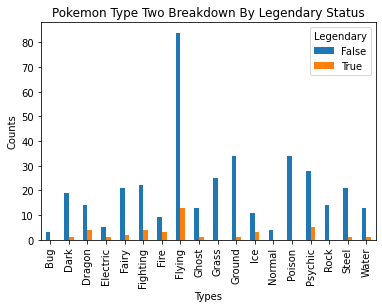

In [25]:
legend_typetwo.unstack(level = 0).plot(kind = 'bar')
plt.title('Pokemon Type Two Breakdown By Legendary Status')
plt.xlabel('Types')
plt.ylabel('Counts')
plt.show()

It seems like in some cases that the second type is inverse to the first type from numbers alone. Based off the odds, it may help to predict which Pokemon would win in a battle.

### Pokemon - Generation

Now let's look at the breakdown in Pokemon based on which generation they are from.

In [26]:
gen_count = pokemon['Generation'].value_counts()
gen_count.sort_index(inplace = True)
gen_count

1    166
2    106
3    160
4    121
5    165
6     82
Name: Generation, dtype: int64

There is disparity for how many Pokemon are in each generation. I don't believe that this would affect the outcomes of Pokemon battles though.

In [27]:
gen_count_df = pd.DataFrame(gen_count)
percentage = []

total_pokemon = gen_count_df['Generation'].sum()
for i in range(1, len(gen_count_df) + 1):
    percent = (gen_count_df['Generation'][i] / total_pokemon) * 100
    percentage.append(round(percent, 2))
    
gen_count_df['Percentage'] = percentage
gen_count_df

,Generation,Percentage
1,166,20.75
2,106,13.25
3,160,20.00
4,121,15.12
5,165,20.62
6,82,10.25


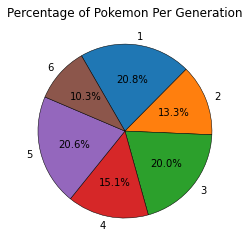

In [28]:
mylabels = gen_count_df.index
wedges = {'edgecolor': 'black', 'linewidth': .5}

plt.pie(gen_count_df['Percentage'], labels = mylabels, autopct = '%1.1f%%', wedgeprops = wedges, counterclock = False, 
       startangle = 120)
plt.title('Percentage of Pokemon Per Generation')
plt.show()


### Pokemon - Legendary

Now let's look in closer detail to the specifics of Legendary Pokemon.

In [29]:
pokemon['Legendary'].value_counts()

False    735
True      65
Name: Legendary, dtype: int64

In [30]:
pokemon.groupby(['Generation'])['Legendary'].sum()

Generation
1     6
2     5
3    18
4    13
5    15
6     8
Name: Legendary, dtype: int64

## Combat

Now, let's take a look at the combats csv. This file will help show trends of Pokemon that have already won many Pokemon battles. My assumption is that this is where most of the information that can help predict Pokemon battles will come from.

In [31]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [32]:
print(f"Dataframe dimensions: {combats.shape}")

Dataframe dimensions: (50000, 3)


In [33]:
print('Below are the columns in the Combats DataFrame:')
print('-----------------------------------------------\n')

for i in range(len(combats.columns)):
    print(f'Column {i}: {combats.columns[i]}')

Below are the columns in the Combats DataFrame:
-----------------------------------------------

Column 0: First_pokemon
Column 1: Second_pokemon
Column 2: Winner


In [34]:
combats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   50000 non-null  int64
 1   Second_pokemon  50000 non-null  int64
 2   Winner          50000 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


In [35]:
combats_profile = ProfileReport(combats, title = "Combats DataFrame Profiling Report")
combats_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

From the report, it looks like 16 Pokemon didn't have a battle recorded. Additionally, out of the 784 Pokemon that did battle, one of those Pokemon never won a battle. 

In [36]:
# https://stackoverflow.com/questions/73505323/pandas-get-values-in-one-column-that-are-not-in-another-column
# https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html

loser = np.setdiff1d(combats['First_pokemon'], combats['Winner'])
print('The Pokemon that never won a battle is: ')
pokemon.loc[pokemon["#"] == loser[0]]

The Pokemon that never won a battle is: 


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False


It seems that Shuckle is the only Pokemon in the recorded battles that didn't win a single battle. Looking at the stats, it seems like the Pokemon has great Defense and Special Defense, but lacks in every other stat. This could mean that Pokemon with high defense and low attack could have a lower percentage of winning battles. 

Now that we know the loser of Pokemon battles, let's find out which Pokemon weren't in a Pokemon battle at all.

In [37]:
# get the unique ID of each Pokemon that didn't have a Pokemon battle in the combats file
fightless_pokemon = []
for i in range(len(pokemon)):
    if pokemon['#'][i] not in combats['First_pokemon'].to_list():
        fightless_pokemon.append(pokemon['#'][i])

In [38]:
# get the full information of each Pokemon that didn't have a Pokemon battle in the combats file
fightless = []
for i in range(len(fightless_pokemon)):
    fightless.append(pokemon.loc[pokemon['#'] == fightless_pokemon[i]]) 

fightless = pd.concat(fightless)
fightless

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False
143,144,Ditto,Normal,NaN,48,48,48,48,48,48,1,False
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False
235,236,Ursaring,Normal,NaN,90,130,75,75,75,55,2,False
321,322,Hariyama,Fighting,NaN,144,120,60,40,60,50,3,False


Above are the 16 different Pokemon who didn't participate in a recorded battle in the combats DataFrame. Next, let's get the win percentage of each Pokemon that has at least one battle in the combats file.

In [39]:
# Add win percentage to pokemon df
# counts how many times a Pokemon shows up in the winner column
# https://sparkbyexamples.com/pandas/pandas-groupby-count-examples/
win_breakdown = combats.groupby(['Winner']).count()
win_breakdown['First_pokemon']

Winner
1       37
2       46
3       89
4       70
5       55
6       64
7      115
8      119
9      114
10      19
11      59
13      83
14      17
15      13
16      75
17      26
18      17
19      80
20     115
21      47
22      64
23     112
24     119
25      65
26     101
27      62
28     103
29      48
30      72
31      93
32     105
34      56
35      20
36      57
37      66
38      34
39      51
40      79
41      20
42      49
43      53
44     103
45      15
47      55
48      97
49       9
50      28
51      44
52      13
53      30
54      32
55      92
56      68
57     108
58      91
59     103
60      47
61      79
62      55
63      85
64      54
65      91
67      90
68      68
69      35
70      87
71     108
72      86
73      21
74      32
75      51
76      23
77      45
79      79
80      94
81      16
82      29
83      50
84      86
85      91
86      24
87      20
88      16
89      24
91      52
92      87
93     121
94      29
95      68
96      25
97 

In [40]:
# counts how many times a Pokemon shows up in the First_pokemon column
first_pokemon_appearance = combats.groupby(['First_pokemon']).count()
first_pokemon_appearance

,Second_pokemon,Winner
First_pokemon,,
1,70,70
2,55,55
3,68,68
4,62,62
5,50,50
6,66,66
7,60,60
8,65,65
9,66,66


In [41]:
# counts how many times a Pokemon shows up in the Second_pokemon column
second_pokemon_appearance = combats.groupby(['Second_pokemon']).count()
second_pokemon_appearance

,First_pokemon,Winner
Second_pokemon,,
1,63,63
2,66,66
3,64,64
4,63,63
5,62,62
6,52,52
7,73,73
8,74,74
9,69,69


In [42]:
# Count the total number of times a Pokemon had a battle
total_battle_appearances = first_pokemon_appearance['Second_pokemon'] + second_pokemon_appearance['First_pokemon']
total_battle_appearances

First_pokemon
1      133
2      121
3      132
4      125
5      112
6      118
7      133
8      139
9      135
10     117
11     141
13     144
14     115
15     133
16     120
17     111
18     130
19     128
20     119
21     126
22     121
23     130
24     126
25     135
26     140
27     138
28     123
29     131
30     125
31     136
32     121
34     105
35     119
36     148
37     122
38     136
39     128
40     140
41     127
42     123
43     129
44     127
45     130
47     145
48     128
49     143
50     129
51     124
52     138
53     154
54     143
55     140
56     126
57     128
58     140
59     120
60     142
61     115
62     118
63     108
64     120
65     114
67     125
68     130
69     108
70     130
71     140
72     110
73     150
74     124
75     116
76     108
77     121
79     157
80     117
81     135
82     137
83     135
84     115
85     105
86     122
87     131
88     116
89     143
91     116
92     134
93     143
94     119
95     131
96     

In [43]:
# get the win percentage of each Pokemon based off how many times they appeared in a battle and how many times they won
win_percentage = win_breakdown['First_pokemon'] / total_battle_appearances
win_percentage

1      0.278195
2      0.380165
3      0.674242
4      0.560000
5      0.491071
6      0.542373
7      0.864662
8      0.856115
9      0.844444
10     0.162393
11     0.418440
13     0.576389
14     0.147826
15     0.097744
16     0.625000
17     0.234234
18     0.130769
19     0.625000
20     0.966387
21     0.373016
22     0.528926
23     0.861538
24     0.944444
25     0.481481
26     0.721429
27     0.449275
28     0.837398
29     0.366412
30     0.576000
31     0.683824
32     0.867769
34     0.533333
35     0.168067
36     0.385135
37     0.540984
38     0.250000
39     0.398438
40     0.564286
41     0.157480
42     0.398374
43     0.410853
44     0.811024
45     0.115385
47     0.379310
48     0.757812
49     0.062937
50     0.217054
51     0.354839
52     0.094203
53     0.194805
54     0.223776
55     0.657143
56     0.539683
57     0.843750
58     0.650000
59     0.858333
60     0.330986
61     0.686957
62     0.466102
63     0.787037
64     0.450000
65     0.798246
67     0

# Combining DataFrames

Now that we have the win percentage of each Pokemon, it is best to combine that with the Pokemon characteristics file.

In [44]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [45]:
wins = win_breakdown['First_pokemon']

In [46]:
# combining the different aspects of the combats file together before combining it with the Pokemon characteristics file
pokemon_battle_info = pd.concat([wins.rename('total wins'), total_battle_appearances.rename('total battles'), win_percentage.rename('win percentage')], axis = 1)

In [47]:
pokemon_battle_info.head()

,total wins,total battles,win percentage
1,37.0,133,0.278195
2,46.0,121,0.380165
3,89.0,132,0.674242
4,70.0,125,0.560000
5,55.0,112,0.491071


In [48]:
# combine details of the combats file with the details of the Pokemon characteristics
combined1 = pd.merge(pokemon, pokemon_battle_info, right_index = True, left_on = '#')
combined1.head(15)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,total wins,total battles,win percentage
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37.0,133,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46.0,121,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89.0,132,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,70.0,125,0.560000
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,55.0,112,0.491071
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False,64.0,118,0.542373
6,7,Charizard,Fire,Flying,78,84,78,109,85,100,1,False,115.0,133,0.864662
7,8,Mega Charizard X,Fire,Dragon,78,130,111,130,85,100,1,False,119.0,139,0.856115
8,9,Mega Charizard Y,Fire,Flying,78,104,78,159,115,100,1,False,114.0,135,0.844444
9,10,Squirtle,Water,NaN,44,48,65,50,64,43,1,False,19.0,117,0.162393


Now we can find out different aspects of Pokemon which lead toward more wins in Pokemon battles.

In [49]:
# find the breakdown of wins based on a Pokemon's first type
typeone_win_breakdown = combined1.groupby(['Type 1'])['win percentage'].mean().sort_values(ascending = False)
typeone_win_breakdown

Type 1
Flying      0.765061
Dragon      0.633587
Electric    0.632861
Dark        0.629726
Fire        0.579215
Psychic     0.545747
Ground      0.541526
Normal      0.535578
Ghost       0.484027
Fighting    0.475616
Water       0.469357
Grass       0.440364
Ice         0.439604
Bug         0.439006
Poison      0.433262
Steel       0.424529
Rock        0.404852
Fairy       0.329300
Name: win percentage, dtype: float64

The three types that had the most Pokemon, Water, Normal, and Grass, didn't make the top three for wins. Only one of the bottom three types made it to the top three in wins.

In [50]:
# get win percentage based on the second type of a Pokemon
typetwo_win_breakdown = combined1.groupby(['Type 2'])['win percentage'].mean().sort_values(ascending = False)
typetwo_win_breakdown

Type 2
Fighting    0.676791
Flying      0.663559
Normal      0.640896
Fire        0.633781
Dragon      0.605966
Dark        0.594685
Ice         0.587451
Electric    0.532644
Psychic     0.510052
Steel       0.500881
Poison      0.452220
Ghost       0.445396
Bug         0.439055
Fairy       0.432114
Grass       0.420361
Water       0.411971
Ground      0.376463
Rock        0.306528
Name: win percentage, dtype: float64

In [51]:
# get win percentage based on the generation a Pokemon is from
generation_win_breakdown = combined1.groupby(['Generation'])['win percentage'].mean().sort_values(ascending = False)
generation_win_breakdown

Generation
4    0.537572
5    0.519201
1    0.518685
6    0.489440
3    0.478484
2    0.450188
Name: win percentage, dtype: float64

In [52]:
# get win percentage based on whether a Pokemon is a legendary Pokemon or not
legendary_win_breakdown = combined1.groupby(['Legendary'])['win percentage'].mean().sort_values(ascending = False)
legendary_win_breakdown

Legendary
True     0.779137
False    0.476829
Name: win percentage, dtype: float64

In [53]:
# look at the top 15 Pokemon for any trends
top_15_pokemon = combined1.sort_values('win percentage', ascending = False)[0:15]
top_15_pokemon

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,total wins,total battles,win percentage
154,155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,1,False,127.0,129,0.984496
512,513,Weavile,Dark,Ice,70,120,65,45,85,125,4,False,116.0,119,0.974790
703,704,Tornadus Therian Forme,Flying,NaN,79,100,80,110,90,121,5,True,121.0,125,0.968000
19,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,1,False,115.0,119,0.966387
153,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,1,False,136.0,141,0.964539
476,477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,4,False,124.0,129,0.961240
726,727,Greninja,Water,Dark,72,95,67,103,71,122,6,False,122.0,127,0.960630
716,717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,5,False,118.0,123,0.959350
164,165,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,True,119.0,125,0.952000
349,350,Mega Sharpedo,Water,Dark,70,140,70,110,65,105,3,False,114.0,120,0.950000


The biggest aspect that sticks out from the top 15 Pokemon is that almost all of the Pokemon have an attack stat and speed stat over 100. Additionally, most of the Pokemon have a defense stat that is below 100. This is the inverse of what Shuckle's stats look like as well.

In [54]:
bottom_15_pokemon = combined1.sort_values('win percentage', ascending = True)[0:15]
bottom_15_pokemon

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,total wins,total battles,win percentage
289,290,Silcoon,Bug,NaN,50,35,55,25,25,15,3,False,3.0,138,0.021739
189,190,Togepi,Fairy,NaN,35,20,65,40,65,20,2,False,3.0,122,0.024590
638,639,Solosis,Psychic,NaN,45,30,40,105,50,20,5,False,4.0,129,0.031008
236,237,Slugma,Fire,NaN,40,40,40,70,40,20,2,False,4.0,123,0.032520
576,577,Munna,Psychic,NaN,76,25,45,67,55,24,5,False,5.0,128,0.039062
188,189,Igglybuff,Normal,Fairy,90,30,15,40,20,15,2,False,5.0,115,0.043478
394,395,Wynaut,Psychic,NaN,95,23,48,23,48,23,3,False,6.0,130,0.046154
209,210,Wooper,Water,Ground,55,45,45,25,25,15,2,False,6.0,125,0.048000
291,292,Cascoon,Bug,NaN,50,35,55,25,25,15,3,False,7.0,133,0.052632
752,753,Spritzee,Fairy,NaN,78,52,60,63,65,23,6,False,8.0,133,0.060150


The bottom 15 Pokemon just have low stats across the board. They have extremely low attack speed stats. There is a good portion of the Pokemon in the bottom 15 who are also basic Pokemon and haven't evolved.

In [55]:
typetwo_null = combined1[combined1['Type 2'].isna()]
typetwo_null.head(10)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,total wins,total battles,win percentage
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,55.0,112,0.491071
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False,64.0,118,0.542373
9,10,Squirtle,Water,NaN,44,48,65,50,64,43,1,False,19.0,117,0.162393
10,11,Wartortle,Water,NaN,59,63,80,65,80,58,1,False,59.0,141,0.418440
12,13,Mega Blastoise,Water,NaN,79,103,120,135,115,78,1,False,83.0,144,0.576389
13,14,Caterpie,Bug,NaN,45,30,35,20,20,45,1,False,17.0,115,0.147826
14,15,Metapod,Bug,NaN,50,20,55,25,25,30,1,False,13.0,133,0.097744
24,25,Rattata,Normal,NaN,30,56,35,25,35,72,1,False,65.0,135,0.481481
25,26,Raticate,Normal,NaN,55,81,60,50,70,97,1,False,101.0,140,0.721429
28,29,Ekans,Poison,NaN,35,60,44,40,54,55,1,False,48.0,131,0.366412


In [56]:
typetwo_null['win percentage'].mean()

0.465803390101582

In [57]:
typetwo_notnull = combined1[combined1['Type 2'].notnull()]
typetwo_notnull.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,total wins,total battles,win percentage
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37.0,133,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46.0,121,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89.0,132,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,70.0,125,0.560000
6,7,Charizard,Fire,Flying,78,84,78,109,85,100,1,False,115.0,133,0.864662


In [58]:
typetwo_notnull['win percentage'].mean()

0.5348908614611735

It seems to help just a small amount to have a second type as a Pokemon when it comes to winning Pokemon battles. However, it doesn't seem to be a huge advantage.

# Preprocessing Data

Now that we are complete with the EDA phase, it is time to build out a few models to run predictions of Pokemon battles.

In [59]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [60]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [61]:
# merge the Pokemon characteristics file and the combats file on the unique ID
merged_data = pokemon.merge(combats, left_on = '#', right_on = 'First_pokemon', how = 'inner')

In [62]:
merged_data.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Winner
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,1,679,679
1,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,1,687,687
2,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,1,557,557
3,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,1,766,766
4,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,1,153,153


In [63]:
# Drop the unique ID, Pokemon Name, and the generation it comes from
merged_data.drop(['#', 'Name', 'Generation'], inplace = True, axis = 1)
merged_data.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,First_pokemon,Second_pokemon,Winner
0,Grass,Poison,45,49,49,65,65,45,False,1,679,679
1,Grass,Poison,45,49,49,65,65,45,False,1,687,687
2,Grass,Poison,45,49,49,65,65,45,False,1,557,557
3,Grass,Poison,45,49,49,65,65,45,False,1,766,766
4,Grass,Poison,45,49,49,65,65,45,False,1,153,153


The unique ID was dropped because it has no say in the winning of Pokemon battles. Additionally, each Pokemon can be determined still based on the First_pokemon column. The Pokemon name isn't needed for the exact same reason. The generation was removed because there isn't any evidence that a generation is more powerful from the next generation. We want to look at the individual stats to determine which Pokemon is going to win.

In [64]:
# time to get dummy variables for the categorical variables
dummy_df = pd.get_dummies(merged_data)
dummy_df.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,First_pokemon,Second_pokemon,Winner,Type 1_Bug,Type 1_Dark,Type 1_Dragon,Type 1_Electric,Type 1_Fairy,Type 1_Fighting,Type 1_Fire,Type 1_Flying,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water,Type 2_Bug,Type 2_Dark,Type 2_Dragon,Type 2_Electric,Type 2_Fairy,Type 2_Fighting,Type 2_Fire,Type 2_Flying,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
0,45,49,49,65,65,45,False,1,679,679,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,45,49,49,65,65,45,False,1,687,687,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,45,49,49,65,65,45,False,1,557,557,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,45,49,49,65,65,45,False,1,766,766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,45,49,49,65,65,45,False,1,153,153,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [65]:
# get the train and test features
train_features = dummy_df.drop('Winner', axis = 1)
test_features = dummy_df['Winner']

In [66]:
# split the data 
x_train, x_test, y_train, y_test = train_test_split(train_features, test_features, test_size = 0.2)

# Linear Regression

The first model is a Linear Regression model.

In [67]:
# build out the model
regression = LinearRegression()
model1 = regression.fit(x_train, y_train)

In [68]:
# predict Pokemon battles
pokemon_winner_pred = model1.predict(x_test)

In [69]:
# get the r2 score of the model 
linear_r2_score = (r2_score(y_test, pokemon_winner_pred)) 
linear_r2_score

0.5137452903706405

# Random Forest

The next model is the Random Forest model.

In [70]:
# create a random forest model
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [71]:
# fit the data
model2 = rf.fit(x_train, y_train)

In [72]:
# run predictions on the random forest model
rf_pred = model2.predict(x_test)

In [73]:
# get the r2 score of the model
rf_r2_score = r2_score(y_test, rf_pred)
rf_r2_score

0.6921776592338134

# XGBoost

The final model is going to be a XGBoost model

In [74]:
# creating the model
xgb = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.08, gamma = 0, subsample = 0.75, colsample_bytree = 1, max_depth = 7)

In [75]:
# fitting the data
model3 = xgb.fit(x_train, y_train)

In [76]:
# running predictions
xgb_pred = model3.predict(x_test)

In [77]:
# getting the r2 score
xgb_r2_score = r2_score(y_test, xgb_pred)
xgb_r2_score

0.7159095561167266